## Probando Modelos

Vamos a revisar si es posible hacer predicciones de los diferentes subtipos de robos en el tiempo, usando un enfoque de series de tiempo multivariada.

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os, sys

root_path = os.path.dirname(os.getcwd())
sys.path.append(root_path)
data_path = os.path.join(root_path, 'data')
model_path = os.path.join(root_path, 'models')

In [13]:
df = pd.read_csv(os.path.join(data_path, 'processed', 'processed.csv'), encoding='utf-8', parse_dates=['date'] )
df.delitos = df.delitos.astype(int)
df.head()

,cod_lugar,cod_subtipo,date,delitos
0,10001-10,R-0,2015-01-01,0
1,10001-10,R-0,2015-02-01,0
2,10001-10,R-0,2015-03-01,0
3,10001-10,R-0,2015-04-01,0
4,10001-10,R-0,2015-05-01,1


In [14]:
df.dtypes

cod_lugar              object
cod_subtipo            object
date           datetime64[ns]
delitos                 int32
dtype: object

Hagamos una prueba. Por el momento, no pensemos en las localidades (cod_lugar). Únicamente estaremos revisando los subtipos de delitos aquí.

In [15]:
df.drop(columns=['cod_lugar'], inplace=True)
df.cod_subtipo.nunique()

18

Podríamos pensar en cada subtipo como una serie de tiempo de forma independiente.

In [17]:
df_piv = df.pivot_table(index='date', columns='cod_subtipo', values='delitos', aggfunc='sum')
df_piv.reset_index(inplace=True)
df_piv.columns.name = None
df_piv.set_index('date', inplace=True)
df_piv.head() 

,R-0,R-1,R-10,R-11,R-12,R-13,R-14,R-15,R-16,R-17,R-2,R-3,R-4,R-5,R-6,R-7,R-8,R-9
date,,,,,,,,,,,,,,,,,,
2015-01-01,3720,6291,443,9,3532,271,20,0,22,7016,374,0,274,228,3097,77,51,836
2015-02-01,3385,5811,409,20,3326,249,19,0,1,6982,356,0,321,243,2946,85,68,765
2015-03-01,3582,6055,443,6,3581,238,14,0,0,7563,524,1,392,247,3196,35,88,852
2015-04-01,3584,5428,402,13,3457,196,15,0,2,6985,534,0,316,201,2951,84,82,818
2015-05-01,3555,5640,486,11,3122,202,13,2,3,7398,574,0,440,207,3206,83,83,652


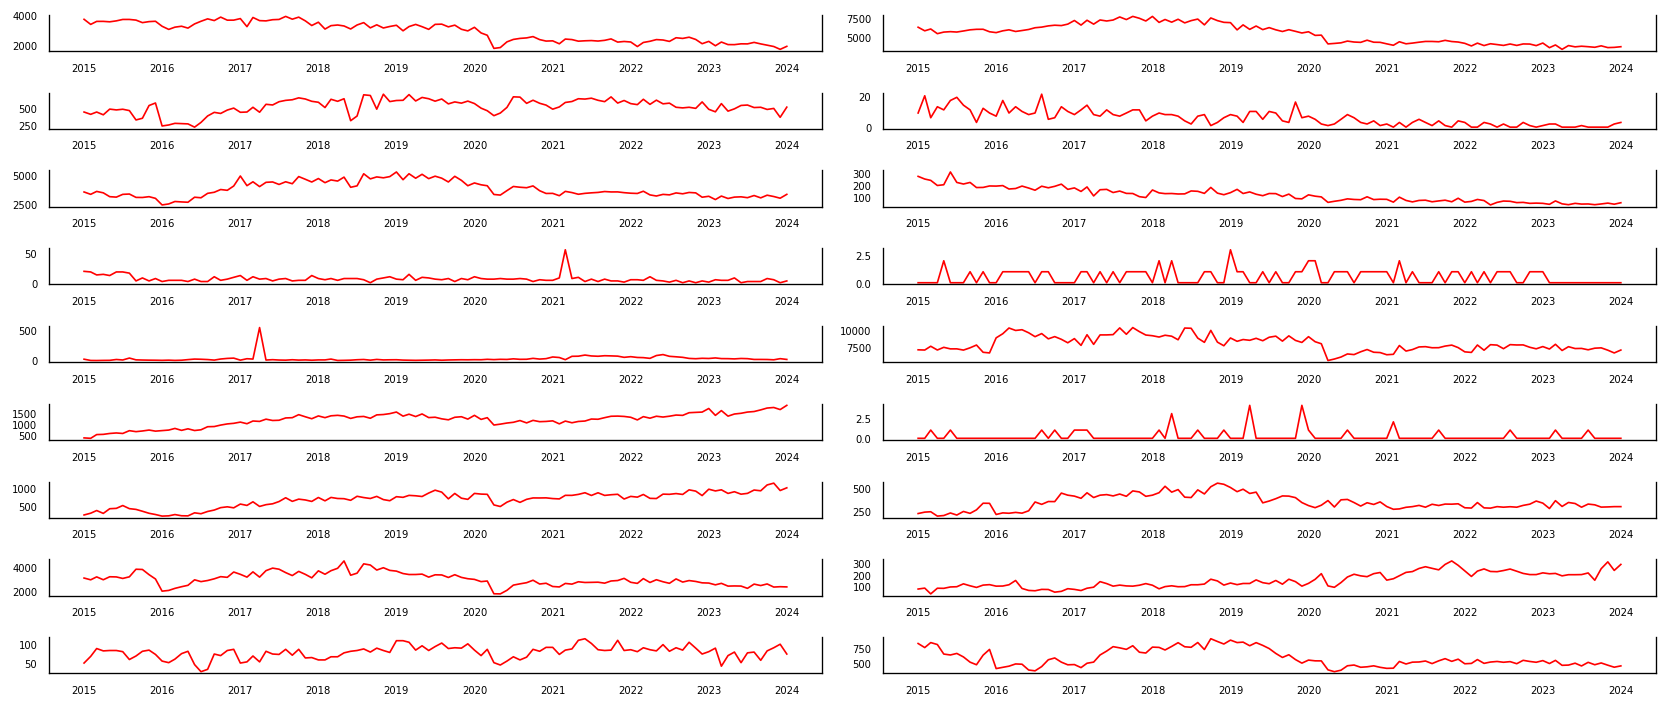

In [18]:

import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=9, ncols=2, dpi=120, figsize=(14,6))
for i, ax in enumerate(axes.flatten()):
    data = df_piv[df_piv.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['top'].set_alpha(0)
    ax.tick_params(labelsize=6)
    plt.tight_layout()

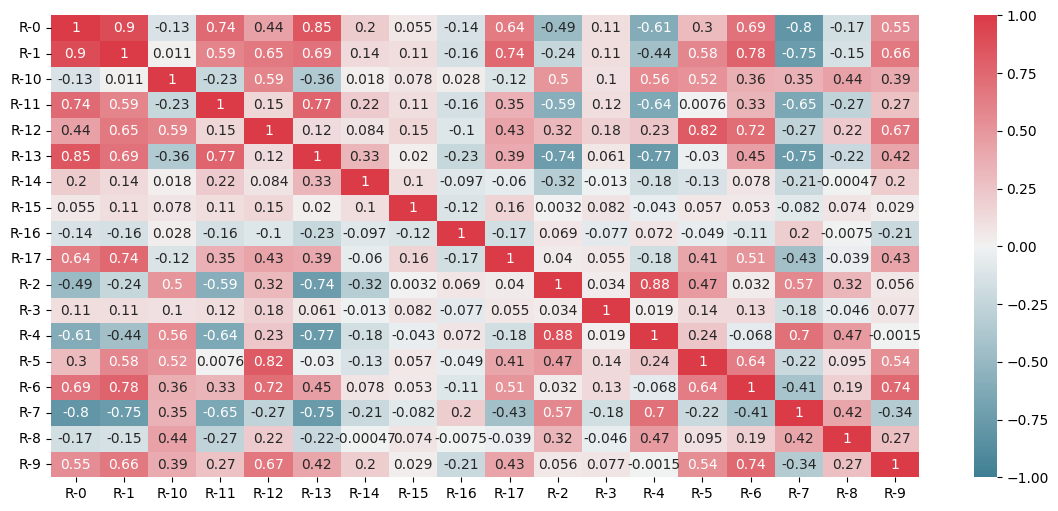

In [20]:
corr=df_piv.corr()
plt.figure(figsize=(14, 6))
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True,vmax=1, vmin=-1, cmap =sns.diverging_palette(220, 10, as_cmap=True),center=0 )
plt.show()

### Prueba de estacionariedad

El primer modelo que quiero probar es el modelo VAR (Vector Autoregression). Este modelo se utiliza para analizar la dinámica de múltiples series de tiempo que interactúan entre sí. (Esto no es necesariamente así con nuestras series)

En el contexto del modelo VAR, tratamos con un vector de variables, donde cada variable representa una serie de tiempo que está interrelacionada con las otras. A cada variable se le realiza un proceso de autoregresión, lo que significa que el valor actual de cada serie de tiempo se escribe en función de sus valores pasados. Lo adicional del modelo es que contempla además los valores pasados de las otras series de tiempo en el modelo. 

El modelo tiene un parámetro, el orden de la autoregresión. 

Necesitamos que los datos sean estacionarios para poder usar el modelo VAR. Vamos a averiguarlo haciendo un Test de Dickey-Fuller aumentado, a cada variable univariante que tiene nuestro dataset.

In [59]:
import statsmodels.tsa.stattools as sts

def augmented_dickey_fuller_statistics(data, column_name):
    time_series = data[column_name]
    result = sts.adfuller(time_series.values)
    return result[1] <= 0.05

count = 0
for col_name  in df_piv.columns:  
    if augmented_dickey_fuller_statistics(df_piv, col_name):
        count +=1
count / 18 > 0.5

False

Contamos los p-valores que son mayores que $0.05$, con los cuales no se rechaza la hipótesis nula de que la serie no es estacionaria. Dado que estos reprecentan menos del $50\%$ con respecto a la contidad de variables, diremos que no es estacionaria.

In [60]:
df_piv_transformed=df_piv.diff().dropna()
count = 0
for col_name  in df_piv_transformed.columns:  
    if augmented_dickey_fuller_statistics(df_piv_transformed, col_name):
        count +=1
count / 18 > 0.5

True

Para el conjunto de prueba y entrenamiento tomaré 1 año de datos, o sea 12 registros.

In [76]:
train = df_piv[:-12]
test =  df_piv[-12:]
train_transformed = df_piv_transformed[:-12]
test_transformed = df_piv_transformed[-12:]

print(train_transformed.shape, test_transformed.shape)

(96, 18) (12, 18)


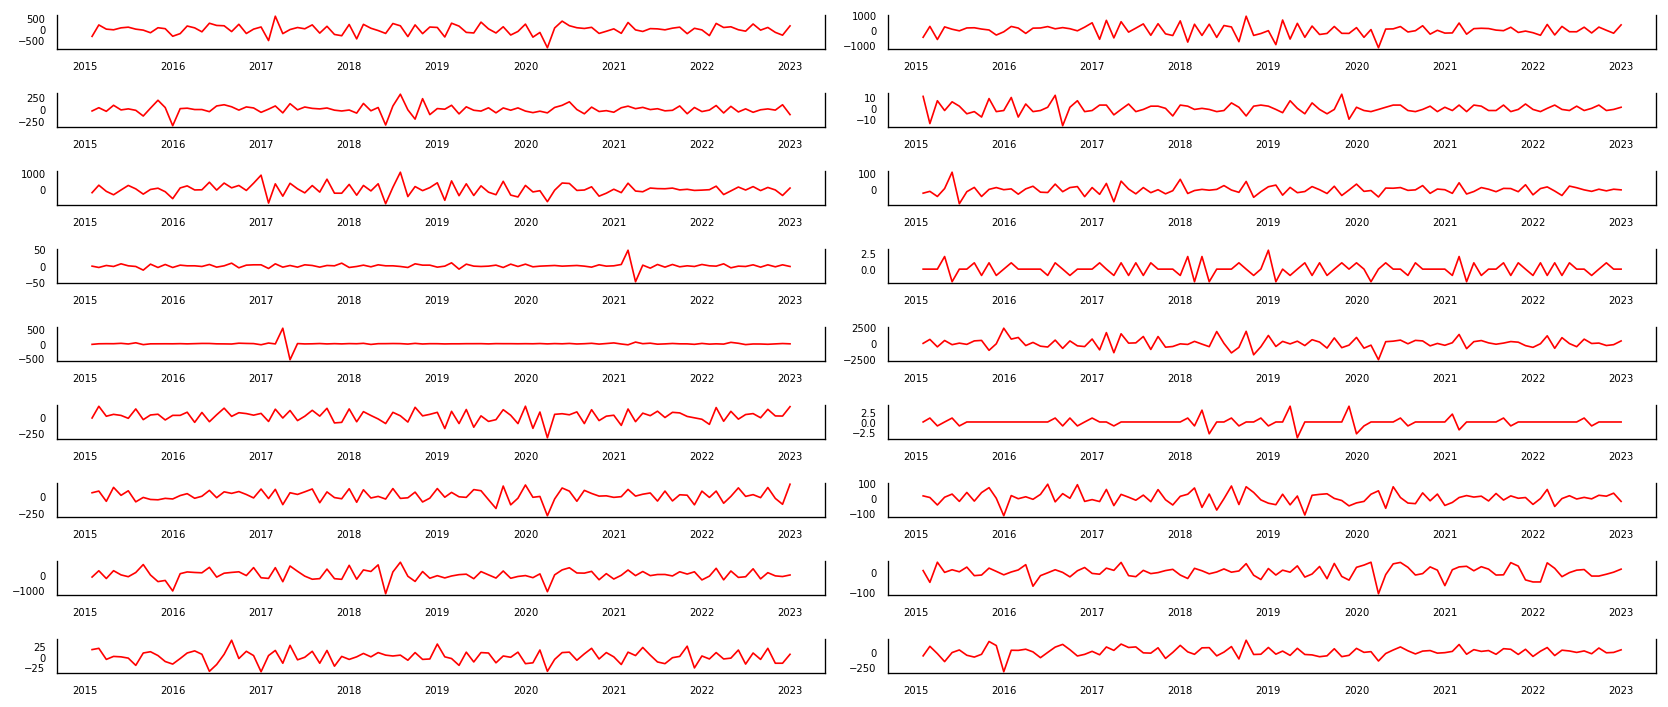

In [64]:
fig, axes = plt.subplots(nrows=9, ncols=2, dpi=120, figsize=(14,6))
for i, ax in enumerate(axes.flatten()):
    data = train_transformed[train_transformed.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['top'].set_alpha(0)
    ax.tick_params(labelsize=6)
    plt.tight_layout();

Para encontrar el parámetro usamos el proceso 'lag order selection', este se refiere a determinar el número óptimo de lags que se deben incluir en el modelo VAR, lo cual se puede hacer utilizando criterios de información como el criterio de información bayesiano (BIC) o el criterio de información Akaike (AIC).

In [65]:
from statsmodels.tsa.api import VAR

model = VAR(train_transformed)
modelsel=model.select_order(4)
modelsel.summary()

d:\Documentos\Proyectos\AlgoSeguros\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,127.5,127.9*,2.258e+55,127.7
1,127.1,136.5,1.821e+55,130.9
2,126.6,144.8,2.222e+55,133.9
3,123.6,150.8,1.328e+55,134.6
4,107.1*,143.1,1.023e+51*,121.7*


In [66]:
res = model.fit(maxlags=4, ic='aic')
res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 07, Mar, 2024
Time:                     09:47:29
--------------------------------------------------------------------
No. of Equations:         18.0000    BIC:                    143.131
Nobs:                     92.0000    HQIC:                   121.650
Log likelihood:          -5962.96    FPE:                1.02337e+51
AIC:                      107.113    Det(Omega_mle):     2.77653e+46
--------------------------------------------------------------------
Results for equation R-0
             coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------
const          31.537850        38.599928            0.817           0.414
L1.R-0          0.618970         0.288773            2.143           0.032
L1.R-1         -0.043067         0.268810           -0.160           0.873
L1.R-10    

Una forma de evaluar el correcto funcionamiento del modelo es observando los residuos. Chequemos los residuos

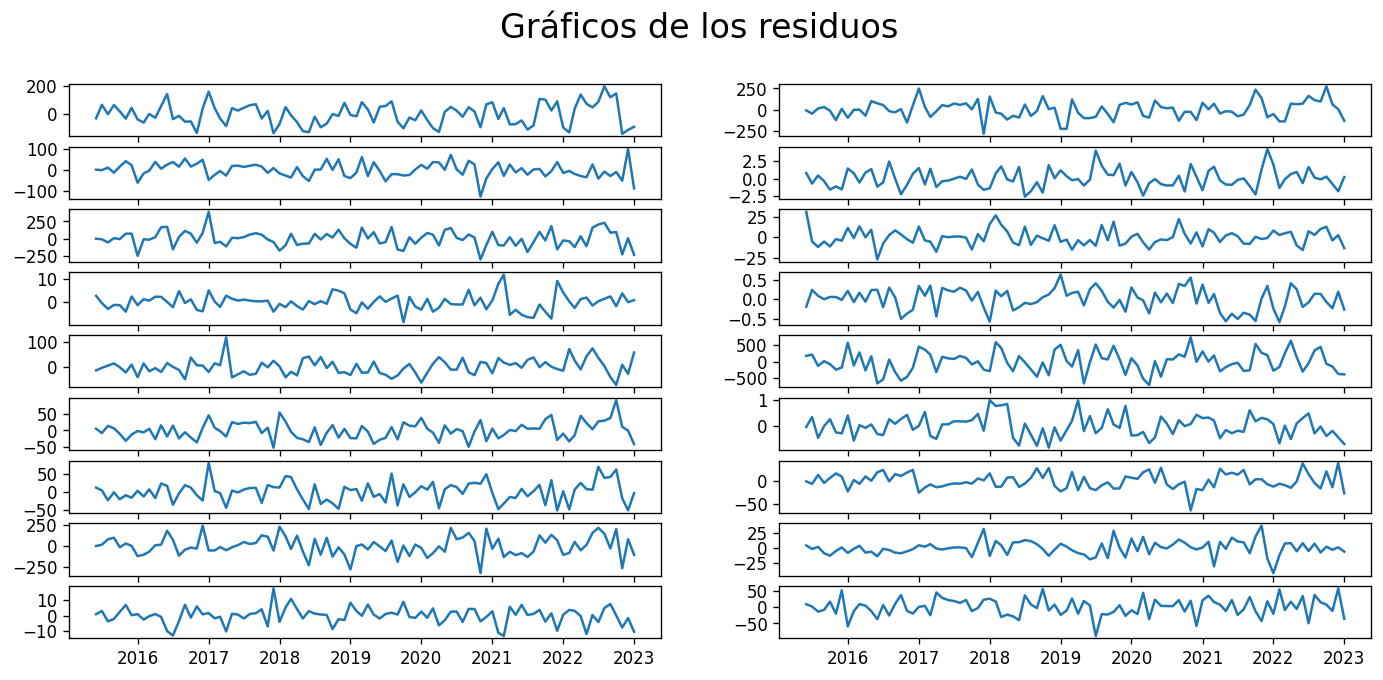

In [69]:
residuals=res.resid
fig, axes = plt.subplots(nrows=9, ncols=2, dpi=120, figsize=(14,6))
fig.suptitle('Gráficos de los residuos',fontsize=20)
for i, ax in enumerate(axes.flatten()):
    ax.plot(residuals.iloc[:,i])
plt.show()

In [70]:
all([sts.adfuller(residuals.iloc[:,i])[1] <= 0.05 for i in range(18)])

True

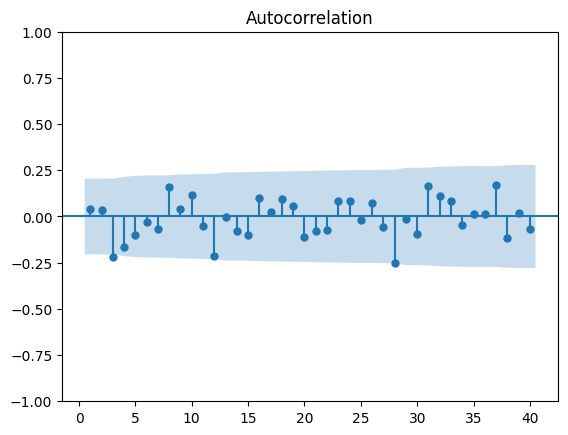

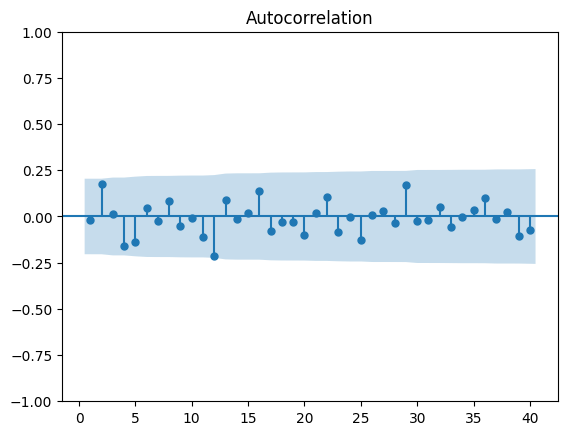

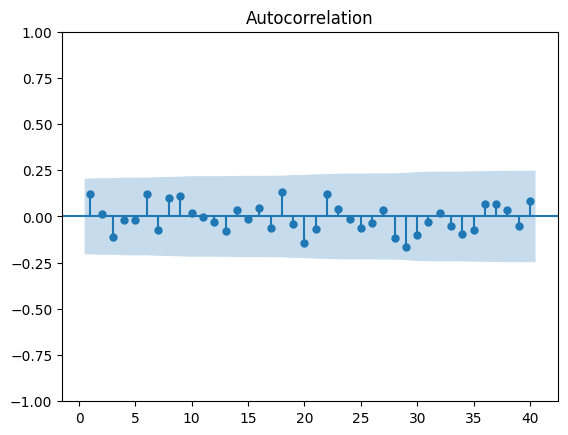

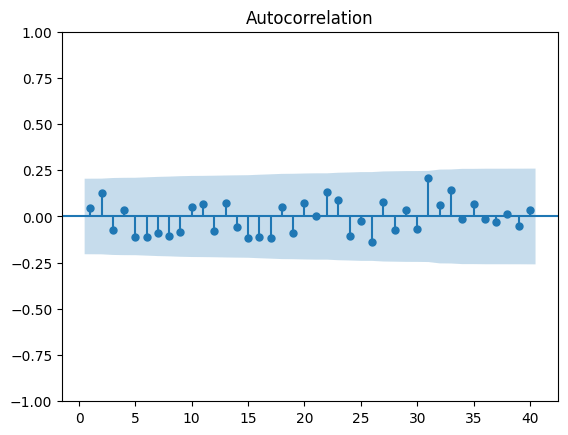

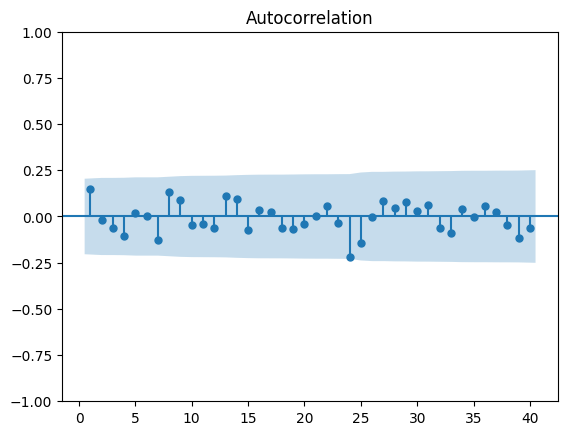

In [71]:
import statsmodels.graphics.tsaplots as sgt
[sgt.plot_acf(residuals.iloc[:,i], zero = False, lags = 40) for i in np.random.randint(0, 18, 5)]
plt.show()

Los residuos del modelo no presentan estructura de autocorrelación, son estacionarios según los resultados de la prueba de Dickey - Fuller aumentada y en los gráficos se puede comprobar esto visualmente, entonces puede concluirse que son ruido blanco como es deseable.

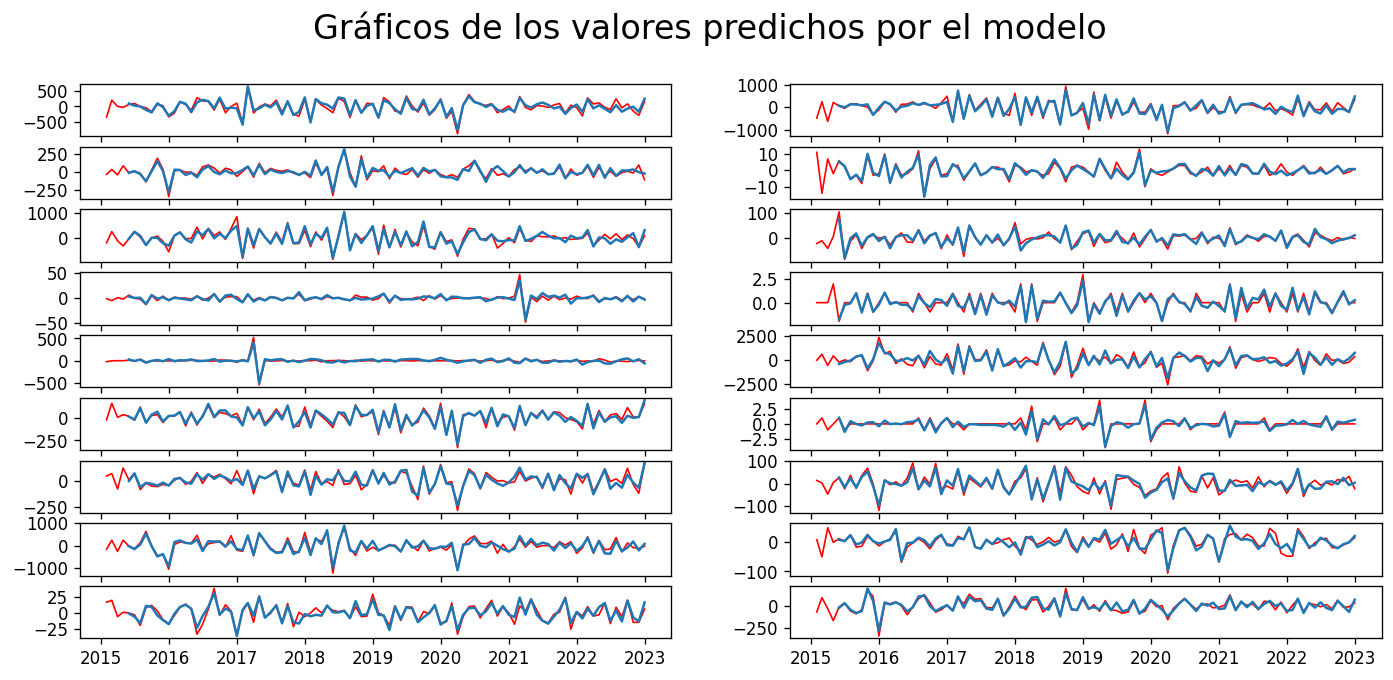

In [72]:
y_fitted = res.fittedvalues

fig, axes = plt.subplots(nrows=9, ncols=2, dpi=120, figsize=(14,6))
fig.suptitle('Gráficos de los valores predichos por el modelo',fontsize=20)
for i, ax in enumerate(axes.flatten()):
    data = train_transformed[train_transformed.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    ax.plot(y_fitted.iloc[:,i])
plt.show()

Para pronosticar, al modelo VAR le podemos pasar hasta el número de orden de retraso de observaciones de los datos pasados. Esto se debe a que los términos en el modelo VAR son esencialmente los retrasos de las diversas series de tiempo en el conjunto de datos, por lo que debemos proporcionar tantos valores anteriores como lo indique el orden de retraso utilizado por el modelo. De lo contrario estaríamos introduciendo poca fiabilidad.

In [73]:
lag_order = res.k_ar
n_obs = test_transformed.shape[0]
print('Orden del modelo:', lag_order)
print('Observaciones a futuro:', n_obs)

Orden del modelo: 4
Observaciones a futuro: 12


In [74]:
input_data = train_transformed.values[-lag_order:]

# Forecasting
pred = res.forecast(y=input_data, steps=n_obs)
pred = (pd.DataFrame(pred, index=test_transformed.index, columns=test_transformed.columns + '_pred'))
print('Predicciones:')
pred

Predicciones:


,R-0_pred,R-1_pred,R-10_pred,R-11_pred,R-12_pred,R-13_pred,R-14_pred,R-15_pred,R-16_pred,R-17_pred,R-2_pred,R-3_pred,R-4_pred,R-5_pred,R-6_pred,R-7_pred,R-8_pred,R-9_pred
date,,,,,,,,,,,,,,,,,,
2023-02-01,-419.066887,-334.164485,-39.595151,-1.640711,-234.506912,-25.751153,-3.873773,1.323348,-88.739329,-47.687859,-33.928998,0.951900,-222.724734,21.736871,-393.393156,-3.420499,-11.172232,68.680377
2023-03-01,-152.901911,-312.745016,-3.028871,-1.302151,-533.580701,-3.814003,7.528482,-2.062423,-2.213105,-184.145019,-54.049803,-1.748661,27.400345,-31.493729,-68.289986,-13.020454,7.876403,-24.750572
2023-04-01,-218.892637,-363.292560,-242.446533,-4.376074,-137.093270,-1.723071,-1.773451,1.469399,-11.153988,410.017091,-51.127224,0.044954,-37.728836,-65.677685,-963.762520,-42.920773,-13.519085,-73.987469
2023-05-01,-13.708538,56.551499,166.716526,4.905150,200.276708,6.227853,1.164612,-0.524517,-19.673356,-161.231198,-55.922101,0.240751,-6.935618,25.781901,495.673949,1.363536,-6.405400,6.479009
2023-06-01,-63.474589,-415.606094,-58.200673,1.889497,-233.653894,-4.604718,-0.250857,-0.493194,-56.910560,88.401427,-57.268969,0.258181,-54.968989,10.243851,-497.047400,1.366809,-8.657050,-96.080590
2023-07-01,53.748096,92.005571,16.197242,0.225087,64.505439,-12.648164,-3.524174,1.123040,75.501194,379.082691,24.388403,-0.449749,4.164655,-28.459722,-107.730961,6.488976,-12.088045,-10.506595
2023-08-01,239.675307,309.297595,25.509276,-0.074721,147.868899,15.843381,-5.963898,-1.129987,-31.249606,355.303445,75.760559,1.047453,55.712145,14.639882,501.905176,11.019823,15.467239,59.865196
2023-09-01,-119.058354,-292.778311,-26.508450,0.536105,-104.854111,-24.056265,3.822779,0.649472,19.207710,-119.645215,-23.063630,-1.014147,-53.290207,-32.889458,-199.279520,-10.435179,-6.879946,-80.988151
2023-10-01,172.963086,261.610316,-8.650046,-2.294691,-8.870936,26.852177,1.364775,-0.103661,-7.762555,354.073196,40.291769,0.262294,56.027146,22.503196,191.909349,6.084811,11.769315,57.446527


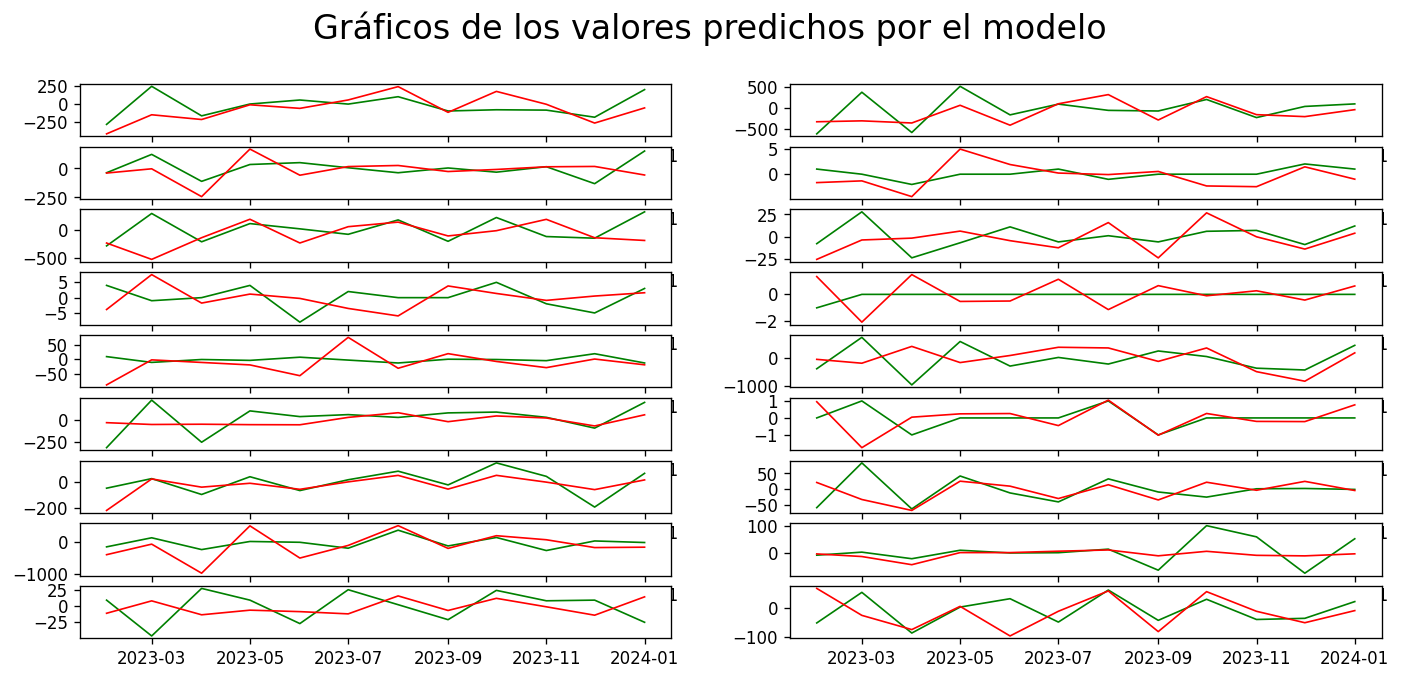

In [75]:
fig, axes = plt.subplots(nrows=9, ncols=2, dpi=120, figsize=(14,6))
fig.suptitle('Gráficos de los valores predichos por el modelo',fontsize=20)
for i, ax in enumerate(axes.flatten()):
    test_data = test_transformed[test_transformed.columns[i]]
    pred_data = pred[pred.columns[i]]
    ax.plot(test_data, color='green', linewidth=1)
    ax.plot(pred_data, color='red', linewidth=1)
    
plt.show()

Los pronósticos se generan en la escala de los datos de entrenamiento utilizados por el modelo, es decir, son datos transformados. Entonces, para volver a ponerlos en su escala original, necesitamos des-diferenciarlos. La forma de invertir la diferenciación es sumar estas diferencias consecutivamente al número base. Una forma sencilla de hacerlo es determinar primero la suma acumulada y luego sumarla al número base. 

In [77]:
def invert_transformation(X_train, pred):
  forecast = pred.copy()
  columns = X_train.columns
  for col in columns:
    forecast[str(col)+'_pred'] = X_train[col].iloc[-1] + forecast[str(col)+'_pred'].cumsum()
  return forecast

pred = invert_transformation(train, pred)


,R-0_pred,R-1_pred,R-10_pred,R-11_pred,R-12_pred,R-13_pred,R-14_pred,R-15_pred,R-16_pred,R-17_pred,R-2_pred,R-3_pred,R-4_pred,R-5_pred,R-6_pred,R-7_pred,R-8_pred,R-9_pred
date,,,,,,,,,,,,,,,,,,
2023-02-01,1848.933113,3840.835515,443.404849,-0.640711,2921.493088,23.248847,-1.873773,2.323348,-54.739329,7466.312141,1665.071002,0.951900,736.275266,359.736871,2275.606844,213.579501,68.827768,606.680377
2023-03-01,1696.031203,3528.090499,440.375978,-1.942862,2387.912387,19.434844,5.654708,0.260924,-56.952434,7282.167122,1611.021199,-0.796760,763.675610,328.243142,2207.316858,200.559048,76.704171,581.929805
2023-04-01,1477.138566,3164.797939,197.929444,-6.318936,2250.819118,17.711772,3.881258,1.730324,-68.106422,7692.184213,1559.893975,-0.751807,725.946774,262.565456,1243.554338,157.638275,63.185086,507.942337
2023-05-01,1463.430028,3221.349438,364.645971,-1.413786,2451.095825,23.939625,5.045870,1.205807,-87.779778,7530.953015,1503.971874,-0.511056,719.011156,288.347358,1739.228287,159.001810,56.779686,514.421345
2023-06-01,1399.955438,2805.743344,306.445298,0.475711,2217.441931,19.334907,4.795013,0.712613,-144.690338,7619.354442,1446.702905,-0.252874,664.042167,298.591209,1242.180887,160.368619,48.122636,418.340755
2023-07-01,1453.703534,2897.748915,322.642540,0.700798,2281.947370,6.686742,1.270840,1.835653,-69.189144,7998.437133,1471.091307,-0.702623,668.206822,270.131487,1134.449925,166.857595,36.034590,407.834161
2023-08-01,1693.378841,3207.046510,348.151816,0.626077,2429.816269,22.530124,-4.693058,0.705667,-100.438751,8353.740578,1546.851866,0.344830,723.918967,284.771369,1636.355101,177.877418,51.501829,467.699357
2023-09-01,1574.320487,2914.268199,321.643365,1.162182,2324.962159,-1.526141,-0.870279,1.355139,-81.231041,8234.095363,1523.788236,-0.669317,670.628760,251.881911,1437.075582,167.442239,44.621884,386.711206
2023-10-01,1747.283573,3175.878514,312.993320,-1.132509,2316.091222,25.326036,0.494496,1.251478,-88.993596,8588.168559,1564.080005,-0.407023,726.655906,274.385106,1628.984930,173.527050,56.391198,444.157733


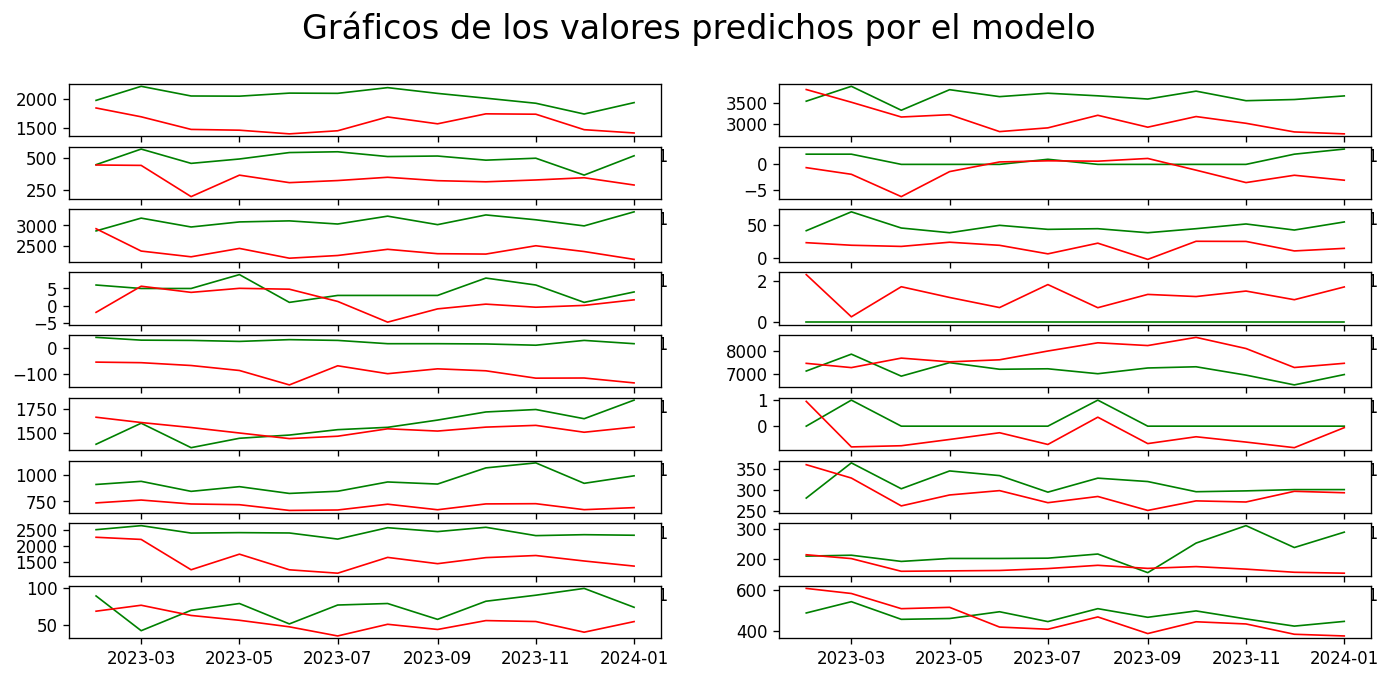

In [78]:
fig, axes = plt.subplots(nrows=9, ncols=2, dpi=120, figsize=(14,6))
fig.suptitle('Gráficos de los valores predichos por el modelo',fontsize=20)
for i, ax in enumerate(axes.flatten()):
    test_data = test[test.columns[i]]
    pred_data = pred[pred.columns[i]]
    ax.plot(test_data, color='green', linewidth=1)
    ax.plot(pred_data, color='red', linewidth=1)
    
plt.show()

En la escala original parece alejarse un poco de la realidad, veamos si podemos revisar otro enfoque